# 0. Imports

In [6]:
!pip install tensorflow 
!pip install music21

In [7]:
import tensorflow as tf
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten,BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output

import os
import numpy as np
from PIL import Image

# 1. Create Dataset

In [8]:
print(os.getcwd())

/home/ec2-user/SageMaker


In [9]:
path = os.getcwd() + '/Image files/Rock - images'

img_list = os.listdir(path)

print(img_list)

['rock00065.png', 'rock00051.png', 'rock00042.png', 'rock00090.png', 'rock00021.png', 'rock00039.png', 'rock00074.png', 'rock00059.png', 'rock00028.png', 'rock00099.png', 'rock00035.png', 'rock00025.png', 'rock00078.png', 'rock00055.png', 'rock00024.png', 'rock00044.png', 'rock00006.png', 'rock00000.png', 'rock00007.png', 'rock00062.png', 'rock00003.png', 'rock00032.png', 'rock00058.png', 'rock00038.png', 'rock00011.png', 'rock00069.png', 'rock00009.png', 'rock00079.png', 'rock00016.png', 'rock00076.png', 'rock00071.png', 'rock00056.png', 'rock00045.png', 'rock00018.png', 'rock00046.png', 'rock00053.png', 'rock00026.png', 'rock00023.png', 'rock00067.png', 'rock00041.png', 'rock00013.png', 'rock00082.png', 'rock00010.png', 'rock00073.png', 'rock00084.png', 'rock00047.png', 'rock00012.png', 'rock00089.png', 'rock00001.png', 'rock00087.png', 'rock00054.png', 'rock00027.png', 'rock00052.png', 'rock00031.png', 'rock00005.png', 'rock00080.png', 'rock00077.png', 'rock00072.png', 'rock00083.pn

In [10]:
def access_images(img_list,path):
    pixels = []
    imgs = []
    for i in range(len(img_list)):
        if 'png' in img_list[i]:
            try:
                img = Image.open(path+'/'+img_list[i],'r')
                img = img.convert('1')
                img = img.resize((106, 106)) # added by me (turns them into smaller images)
                pix = np.array(img.getdata())
                pix = pix.astype('float32')
                pix /= 255.0
                pixels.append(pix.reshape(106, 106, 1))
                imgs.append(img)
            except:
                pass
    return np.array(pixels),imgs

In [11]:
def show_image(pix_list):
    array = np.array(pix_list.reshape(106,106), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()

In [12]:
pixels,imgs = access_images(img_list,path)

In [13]:
np.shape(pixels)

(100, 106, 106, 1)

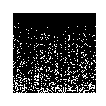

In [14]:
imgs[0]

# 2. Define discriminator and generator  

In [15]:
def define_discriminator(in_shape = (106,106,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate = 0.0002, beta_1=0.5) # lr was deprecated
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [16]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 53 * 53
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((53, 53, 128)))
    model.add(Dense(1024))
    model.add(Conv2DTranspose(1024, (4,4), strides=(2,2), padding='same'))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))
    return model

# 3. Put them together to define the full GAN 

In [17]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# 4. Define functions to generate fake and real points

In [18]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y


 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input



def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

# 5. Train the model 

In [19]:
# 51 is way too many epochs

In [20]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=15, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
#         if (i+1) % 10 == 0:
#             print("Iteration: ", i)
#             summarize_performance(i, g_model, d_model, dataset, latent_dim)
#             clear_output()

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim)

(100, 106, 106, 1)
>1, 1/10, d=0.512, g=0.680
>1, 2/10, d=0.447, g=0.742
>1, 3/10, d=0.370, g=0.701
>1, 4/10, d=0.148, g=0.701
>1, 5/10, d=0.116, g=0.705
>1, 6/10, d=0.102, g=0.681
>1, 7/10, d=0.048, g=0.686
>1, 8/10, d=0.221, g=0.630
>1, 9/10, d=0.125, g=0.607
>1, 10/10, d=0.061, g=0.604
>2, 1/10, d=0.031, g=0.581
>2, 2/10, d=0.027, g=0.549
>2, 3/10, d=0.017, g=0.534
>2, 4/10, d=0.045, g=0.524
>2, 5/10, d=0.023, g=0.513
>2, 6/10, d=0.031, g=0.503
>2, 7/10, d=0.023, g=0.500
>2, 8/10, d=0.012, g=0.479
>2, 9/10, d=0.076, g=0.441
>2, 10/10, d=0.175, g=0.440
>3, 1/10, d=0.425, g=0.443
>3, 2/10, d=0.431, g=0.510
>3, 3/10, d=0.235, g=0.697
>3, 4/10, d=0.326, g=0.738
>3, 5/10, d=0.587, g=0.505
>3, 6/10, d=0.104, g=0.564
>3, 7/10, d=0.345, g=0.497
>3, 8/10, d=0.246, g=0.565
>3, 9/10, d=0.184, g=0.462
>3, 10/10, d=0.109, g=0.575
>4, 1/10, d=0.060, g=0.497
>4, 2/10, d=0.203, g=0.495
>4, 3/10, d=0.110, g=0.454
>4, 4/10, d=0.128, g=0.492
>4, 5/10, d=0.106, g=0.410
>4, 6/10, d=0.076, g=0.438
>4, 7/

# 6. Use newly trained generator to generate new song images

In [ ]:
from keras.models import load_model
from numpy.random import randn
import matplotlib.pyplot as plt

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [ ]:
number_images = 0

while number_images < 10: 
    latent_points = generate_latent_points(latent_dim,1)
    X = g_model.predict(latent_points)
    # A one in the discriminator means it thinks it is real
    prediction = np.round(d_model.predict(X)[0][0])
    
    if prediction == 1: 
        arr = np.array(X.reshape(106,106),dtype = np.uint8);
        arr*= 255;
        new_image = Image.fromarray(arr,'L')
        plt.figure(); 
        plt.imshow(new_image);
        new_image.save('04_16_attempt_1_rock_music_15_epochs_OutputNumber_' + str(number_images) + '.png')
        number_images += 1

# 7. Save model 

In [41]:
g_model.save('04-16-classical-music-generator')

INFO:tensorflow:Assets written to: 04-16-classical-music-generator/assets


In [46]:
g_model.save('04-16-classical-music-generator.h5')

In [42]:
d_model.save('04-16-classical-music-discriminator')

INFO:tensorflow:Assets written to: 04-16-classical-music-discriminator/assets


In [47]:
d_model.save('04-16-classical-music-discriminator.h5')

In [43]:
gan_model.save('04-16-classical-music-full-gan')

INFO:tensorflow:Assets written to: 04-16-classical-music-full-gan/assets


In [48]:
gan_model.save('04-16-classical-music-full-gan.h5')

# 8. Convert

In [36]:
from music21 import midi

In [37]:
ex = 0; 
image2midi('04_16_attempt_1_classical_music_10_epochs_OutputNumber_' + str(ex) + '.png')

NameError: name 'image2midi' is not defined